# CAPTCHA Recognition Challenge
### Problem Description
- 10 000 images, each 65x25 pixels, where each CAPTCHA has 4 characters
- The characters include digits (2345789) and uppercase letters (ABCDEFHKLMNPRTUVWXYZ) = 27 unique symbols.
- The images are in grayscale, characters have different thickness and fill color
- Curved/crooked line is drawn over the CAPTCHA text

### Preprocessing
I tried out different things for preprocessing: removing the line using a Hough transform and adding random pixels to simulate noise. However, the line removal cut off parts of the characters and both methods lowered prediction accuracy. I read that modern OCR models can handle such noise, so I decided not to remove the line.

Instead, I cropped 3 pixels from the left and right sides to make the images a bit cleaner without losing character details.

### Model and Training
At first, I kept the original model architecture and tried adjusting the training parameters by increasing the training data, lowering the learning rate, increasing the batch size, and adding early stopping.

Later, I enhanced the model by improving the CNN layers and using a bidirectional LSTM, along with spatial dropout to reduce overfitting. I also added a OneCycleLR scheduler, which helped improve accuracy further.

### Visualizing Mistakes
After training, the model reached over 99% accuracy. I noticed that sometimes the model predicted 3 or 5 characters instead of 4. Common errors were confusing similar-looking characters, such as "A" with "4", "P" with "B", and "B" with "8". Also, often wrong predictions happened when characters overlapped eachother.

### Conclusion
The final model achieved performance with over 99% accuracy. Minor mistakes are caused by similar-looking characters and overlaps between characters.

### Package Installation and Environment Setup
* Install required packages
* Check PyTorch installation and CUDA availability

In [79]:
!pip install numpy torch torchvision pillow matplotlib tqdm gdown
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4


### Download and Extract CAPTCHA Images from Google Drive

In [80]:
import os
import gdown
from pathlib import Path
import zipfile
import shutil

# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('data/images', exist_ok=True)

file_id = '1Qy4geTaJqoRPuaut8V-VFQYpnQS4gTds'
output = 'data/captcha_images.zip'
CAPTCHA_DIR = 'data/images'

print("Downloading CAPTCHA images from Google Drive...")
try:
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, output, quiet=False)
    print("Download complete!")
    print("Extracting ZIP file...")
    try:
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall('data')
        print("Extraction complete!")

        # Check where the PNG files actually went and move them if needed
        data_dir_files = [f for f in os.listdir('data') if f.lower().endswith('.png')]

        if data_dir_files:
            print(f"Found {len(data_dir_files)} PNG files in 'data' directory")
            print("Moving files to 'data/images'...")

            # Move all PNG files from 'data' to 'data/images'
            for file in data_dir_files:
                src_path = os.path.join('data', file)
                dst_path = os.path.join('data/images', file)
                shutil.move(src_path, dst_path)

            print(f"Successfully moved {len(data_dir_files)} PNG files to 'data/images'")
        else:
            # Check if images might be in a subdirectory
            png_files = []
            for root, dirs, files in os.walk("data"):
                for file in files:
                    if file.lower().endswith('.png'):
                        full_path = os.path.join(root, file)
                        png_files.append(full_path)

            if png_files:
                print(f"Found {len(png_files)} PNG files in subdirectories")
                print("First few files:")
                for file in png_files[:5]:
                    print(f"  - {file}")

                # Extract the directory where most images are
                dir_counts = {}
                for file in png_files:
                    parent_dir = os.path.dirname(file)
                    dir_counts[parent_dir] = dir_counts.get(parent_dir, 0) + 1

                # Find directory with most images
                most_common_dir = max(dir_counts.items(), key=lambda x: x[1])[0]
                print(f"Most images found in: {most_common_dir}")

                # Update CAPTCHA_DIR to this location
                CAPTCHA_DIR = most_common_dir
            else:
                print("No PNG files found after extraction")
                CAPTCHA_DIR = 'data/images'  # Default location

    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid ZIP file.")
        print("Please upload a valid ZIP file containing CAPTCHA images")
except Exception as e:
    print(f"Error downloading or extracting the file: {str(e)}")
    print("Please upload the CAPTCHA images manually")

Downloading...
From (original): https://drive.google.com/uc?id=1Qy4geTaJqoRPuaut8V-VFQYpnQS4gTds
From (redirected): https://drive.google.com/uc?id=1Qy4geTaJqoRPuaut8V-VFQYpnQS4gTds&confirm=t&uuid=92e77a6f-4350-41fb-8186-bb2477be8354
To: /content/data/captcha_images.zip
100%|██████████| 16.4M/16.4M [00:00<00:00, 64.7MB/s]


Download complete!
Extracting ZIP file...
Extraction complete!
Found 10000 PNG files in 'data' directory
Moving files to 'data/images'...
Successfully moved 10000 PNG files to 'data/images'


In [81]:
def extract_label_sets(image_dir):
    # List all PNG files in the directory
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.png')]

    all_labels = []
    for file in image_files:
        label = os.path.splitext(file)[0]
        all_labels.append(label)

    combined_labels = "".join(all_labels)

    digits = {ch for ch in combined_labels if ch.isdigit()}
    letters = {ch for ch in combined_labels if ch.isalpha()}

    return digits, letters

digits, letters = extract_label_sets(CAPTCHA_DIR)

print("Unique digits in labels:", sorted(digits))
print("Unique letters in labels:", sorted(letters))


Unique digits in labels: ['2', '3', '4', '5', '7', '8', '9']
Unique letters in labels: ['A', 'B', 'C', 'D', 'E', 'F', 'H', 'K', 'L', 'M', 'N', 'P', 'R', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


### CAPTCHA Recognition Challenge

In this notebook, we'll build a baseline model for recognizing text in CAPTCHA images.
CAPTCHAs (Completely Automated Public Turing test to tell Computers and Humans Apart)
are distorted text images designed to be difficult for computers to read.

Your task is to improve this baseline model in one of the following ways:
1. Add data augmentation for better robustness
2. Modify the architecture to reduce inference time
3. Improve preprocessing to handle noise

The baseline model achieves approximately 40-60% accuracy with high variance.
Your goal is to demonstrate measurable improvement over this baseline.

In [82]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Constant for CTC blank token
BLANK_TOKEN = 0

### Configuration

This Config class contains all the parameters for our model and training process.
You might want to experiment with these values as you improve the model.

In [83]:
class Config:
    # Model parameters
    IMG_WIDTH = 59 # ORIGINAL WAS 65
    IMG_HEIGHT = 25
    DROPOUT_RATE = 0.3

    # Training parameters
    BATCH_SIZE = 128 # INCREASED FROM 64 TO 128
    LEARNING_RATE = 0.001 # DECREASED FROM 0.01 TO 0.001
    NUM_EPOCHS = 30

    # Dataset parameters
    TARGET_FOLDER = CAPTCHA_DIR
    MAX_SAMPLES = 10000            # INCREASED
    TRAIN_RATIO = 0.9             # Ratio of training to validation data

    # Misc
    RANDOM_SEED = 42
    MODEL_SAVE_PATH = 'captcha_model.pth'

CONFIG = Config()

### Dataset Class
The CaptchaDataset class handles loading and preprocessing CAPTCHA images.
It converts the images to tensors and prepares the labels for training.

In [84]:

class CaptchaDataset(Dataset):
    def __init__(self, image_paths, labels, char_to_idx, max_length, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.char_to_idx = char_to_idx
        self.max_length = max_length


        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('L')  # Convert to grayscale

            if self.transform:
                image = self.transform(image)

            label = self.labels[idx]
            label_indices = [self.char_to_idx[c] for c in label]
            label_length = len(label)

            # Pad label to max_length
            label_indices = label_indices + [BLANK_TOKEN] * (self.max_length - label_length)

            return {
                'image': image,
                'label': torch.tensor(label_indices, dtype=torch.long),
                'label_length': torch.tensor(label_length, dtype=torch.long)
            }
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            return {
                'image': torch.zeros((1, CONFIG.IMG_HEIGHT, CONFIG.IMG_WIDTH)),
                'label': torch.tensor([BLANK_TOKEN] * self.max_length, dtype=torch.long),
                'label_length': torch.tensor(0, dtype=torch.long)
            }

### Model Architecture

Our baseline model architecture has three main components:
1. CNN layer for feature extraction
2. Bidirectional LSTM for sequence modeling
3. Linear layer for classification


In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CaptchaModel(nn.Module):
    def __init__(self, num_chars, dropout_rate=CONFIG.DROPOUT_RATE):
        super().__init__()

        # CNN for feature extraction
        # It consists of two convolution blocks:
        #   - The first block increases the number of channels from 1 to 32
        #   - The second block processes the features and increases channels to 64
        self.cnn = nn.Sequential(

            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)

        )

        # Projection Layer
        # After the CNN each column of the feature map is a vector of size 64*6
        # The linear layer projects it to a 96-dimensional vector for the LSTM
        self.projection = nn.Linear(64 * 6, 96)

        # Dropout
        # Spatial dropout for the CNN feature maps
        self.dropout = nn.Dropout2d(dropout_rate)

        # LSTM for sequence modeling
        self.lstm = nn.LSTM(
            input_size=96,
            hidden_size=96,
            bidirectional=True,
            batch_first=True
        )

        # Classifier
        # The LSTM outputs features of size 96 * 2
        # The linear layer maps LSTM outputs to logits for each character
        self.classifier = nn.Linear(96 * 2, num_chars + 1)

    def forward(self, x):
        # Extract CNN features
        features = self.cnn(x)
        features = self.dropout(features)

        # Reshape the features for sequence modeling
        batch_size, channels, height, width = features.size()
        sequence = features.permute(0, 3, 1, 2).reshape(batch_size, width, channels * height)

        # Project the features to match the LSTM input dimension
        sequence = self.projection(sequence)

        # Process the sequence with the LSTM
        sequence, _ = self.lstm(sequence)

        # Classify each time step.
        logits = self.classifier(sequence)

        # Return log probabilities
        return F.log_softmax(logits, dim=2)


### Data Loading and Preparation
These functions handle:
- Loading the images and labels
- Creating character mappings
- Creating DataLoaders for training and validation

In [86]:
def load_and_prepare_data():
    try:
        # Get all PNG files from the CAPTCHA_DIR
        if os.path.isdir(CONFIG.TARGET_FOLDER):
            # If TARGET_FOLDER is a directory, list PNG files directly from it
            dir_img = [os.path.join(CONFIG.TARGET_FOLDER, f)
                      for f in os.listdir(CONFIG.TARGET_FOLDER)
                      if f.lower().endswith('.png')]
        else:
            # If not, use the list of files we already found
            dir_img = [f for f in png_files if f.lower().endswith('.png')]

        if not dir_img:
            raise FileNotFoundError(f"No images found in {CONFIG.TARGET_FOLDER}")

        # Set random seed for reproducibility
        np.random.seed(CONFIG.RANDOM_SEED)
        np.random.shuffle(dir_img)

        # Limit number of samples
        if CONFIG.MAX_SAMPLES and CONFIG.MAX_SAMPLES < len(dir_img):
            dir_img = dir_img[:CONFIG.MAX_SAMPLES]

        # Extract labels from filenames (assuming filename is the label)
        img_labels = [os.path.splitext(os.path.basename(img))[0] for img in dir_img]

        # Create character mappings
        char_img = sorted(list(set(char for label in img_labels for char in label)))
        char_to_idx = {char: idx+1 for idx, char in enumerate(char_img)}
        idx_to_char = {idx+1: char for idx, char in enumerate(char_img)}

        # Find maximum label length for padding
        max_length = max(len(label) for label in img_labels)

        # Create image transforms
        transform = transforms.Compose([

        Preprocess(),

        transforms.Resize((CONFIG.IMG_HEIGHT, CONFIG.IMG_WIDTH)),
        transforms.ToTensor(),                                  ])

        # Split data into train and validation sets
        train_size = int(len(dir_img) * CONFIG.TRAIN_RATIO)
        train_img = dir_img[:train_size]
        train_labels = img_labels[:train_size]
        val_img = dir_img[train_size:]
        val_labels = img_labels[train_size:]

        # Create datasets
        train_dataset = CaptchaDataset(train_img, train_labels, char_to_idx, max_length, transform)
        val_dataset = CaptchaDataset(val_img, val_labels, char_to_idx, max_length, transform)

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

        # Log dataset information
        print(f"Total samples: {len(dir_img)}")
        print(f"Training samples: {len(train_img)}")
        print(f"Validation samples: {len(val_img)}")
        print(f"Character set: {''.join(char_img)}")

        return train_loader, val_loader, idx_to_char, max_length

    except Exception as e:
        print(f"Error preparing data: {e}")
        raise


In [87]:
def preprocess(image):
    # Add cropping (assuming image is a PIL Image)
    width, height = image.size
    crop_left = 3
    crop_right = width - 3
    cropped_image = image.crop((crop_left, 0, crop_right, height))

    return cropped_image

In [88]:
class Preprocess:
    def __call__(self, img):
        img = preprocess(img)
        return img


### Decoding and Evaluation Functions
These functions handle:
- Decoding model outputs into text predictions
- Evaluating model accuracy and loss


In [89]:
def decode_predictions(outputs, idx_to_char):
    """Convert model outputs to text predictions"""
    predictions = []
    output_args = torch.argmax(outputs.detach().cpu(), dim=2)

    for pred in output_args:
        text = ''
        prev_char = None

        for p in pred:
            p_item = p.item()
            # Only add character if it's not blank and not a repeat
            if p_item != BLANK_TOKEN and p_item != prev_char:
                if p_item in idx_to_char:
                    text += idx_to_char[p_item]
            prev_char = p_item

        predictions.append(text)

    return predictions

def get_text_from_indices(indices, idx_to_char, length):
    """Convert indices to text"""
    return ''.join([idx_to_char[idx.item()]
                  for idx in indices[:length]
                  if idx.item() != BLANK_TOKEN and idx.item() in idx_to_char])

def evaluate_with_loss(model, data_loader, device, idx_to_char, criterion):
    """Evaluate model with both accuracy and loss calculation"""
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            images = batch['image'].to(device)
            labels = batch['label']
            label_lengths = batch['label_length']

            outputs = model(images)
            predictions = decode_predictions(outputs, idx_to_char)

            # Calculate loss
            outputs_trans = outputs.transpose(0, 1)
            input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long)
            loss = criterion(outputs_trans, labels, input_lengths, label_lengths)
            val_loss += loss.item()

            # Calculate accuracy
            true_texts = []
            for i, label in enumerate(labels):
                label_length = label_lengths[i].item()
                text = get_text_from_indices(label, idx_to_char, label_length)
                true_texts.append(text)

            for pred, true in zip(predictions, true_texts):
                if pred == true:
                    correct += 1
                total += 1

    accuracy = (correct / total) * 100 if total > 0 else 0
    avg_loss = val_loss / len(data_loader) if len(data_loader) > 0 else float('inf')
    return accuracy, avg_loss, correct, total

## Visualization Functions
These functions handle:
- Visualizing sample images from the dataset
- Plotting training history

In [90]:
def visualize_dataset_samples(data_loader, idx_to_char, num_samples=16):
    """Visualize sample images from the dataset with their labels"""
    batch = next(iter(data_loader))
    images = batch['image']
    labels = batch['label']
    label_lengths = batch['label_length']

    # Calculate grid dimensions
    grid_size = min(num_samples, len(images))
    cols = 4
    rows = (grid_size + cols - 1) // cols

    plt.figure(figsize=(12, 3 * rows))

    for i in range(grid_size):
        plt.subplot(rows, cols, i + 1)

        # Convert tensor to numpy and display image
        img = images[i].squeeze().numpy()
        plt.imshow(img, cmap='gray')

        # Get the original text label
        label_length = label_lengths[i].item()
        text = get_text_from_indices(labels[i], idx_to_char, label_length)

        plt.title(f"Label: {text}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_history(history):
    """Plot training history metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot validation accuracy
    ax2.plot(history['val_accuracy'])
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [91]:
def visualize_misclassifications(model, data_loader, device, idx_to_char, num_samples=10000):
    """
    Display examples of images where the model's prediction did notmatch the label.
    """
    model.eval()
    misclassified = []  # stores tuples of (image_tensor, predicted_str, true_str)

    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)
            labels = batch['label']
            label_lengths = batch['label_length']

            # Get model outputs and decode
            outputs = model(images)
            predictions = decode_predictions(outputs, idx_to_char)

            # Convert true labels to strings
            true_labels = []
            for i, lbl in enumerate(labels):
                length = label_lengths[i].item()
                text = get_text_from_indices(lbl, idx_to_char, length)
                true_labels.append(text)

            # Compare and collect misclassifications
            for i in range(len(images)):
                if predictions[i] != true_labels[i]:
                    # Store the raw image and the strings
                    misclassified.append((
                        images[i].cpu(),
                        predictions[i],
                        true_labels[i]
                    ))

            if len(misclassified) >= num_samples:
                break

    misclassified = misclassified[:num_samples]

    if not misclassified:
        print("No misclassifications.")
        return

    # Plot
    plt.figure(figsize=(8, 2 * len(misclassified)))

    for i, (img_tensor, pred_str, true_str) in enumerate(misclassified):
        img_np = img_tensor.numpy().squeeze()
        plt.subplot(len(misclassified), 1, i + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"Predicted: {pred_str} | True: {true_str}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


### Training and Execution

Total samples: 10000
Training samples: 9000
Validation samples: 1000
Character set: 2345789ABCDEFHKLMNPRTUVWXYZ
Visualizing sample images from dataset:


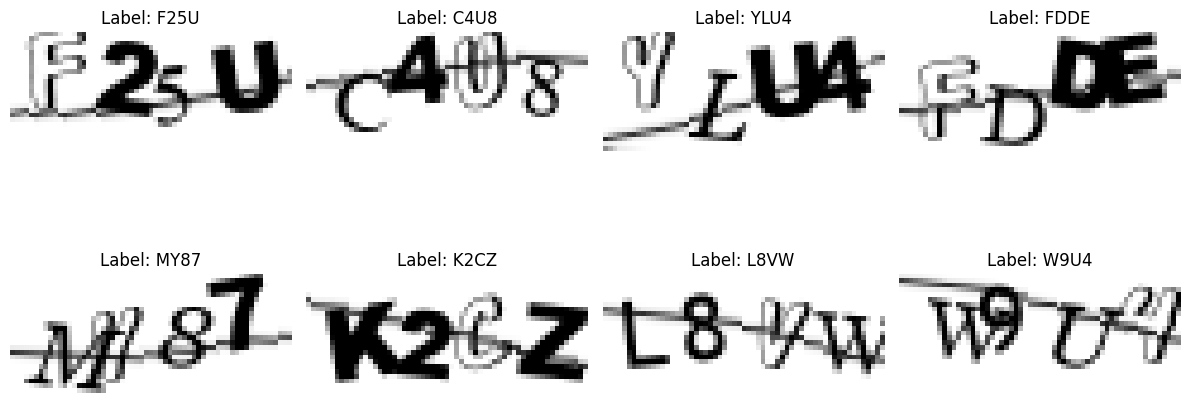

Model architecture:
CaptchaModel(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (projection): Linear(in_features=384, out_features=96, bias=True)
  (dropout): Dropout2d(p=0.3, inplace=False)
  (lstm): LSTM(96, 96, batch_first=True, bidirectional=True)
  (classifier): Linear(

Epoch 1/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 4.2250, Val Loss: 3.6206, Validation Accuracy: 0.00% (0/1000)


Epoch 2/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 3.6159, Val Loss: 3.6070, Validation Accuracy: 0.00% (0/1000)


Epoch 3/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 3.4393, Val Loss: 5.0090, Validation Accuracy: 0.00% (0/1000)


Epoch 4/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 2.0827, Val Loss: 2.3688, Validation Accuracy: 1.10% (11/1000)


Epoch 5/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.6564, Val Loss: 0.5742, Validation Accuracy: 44.80% (448/1000)


Epoch 6/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.2689, Val Loss: 0.1766, Validation Accuracy: 80.00% (800/1000)


Epoch 7/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.1290, Val Loss: 0.0742, Validation Accuracy: 91.70% (917/1000)


Epoch 8/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.0802, Val Loss: 0.1283, Validation Accuracy: 83.20% (832/1000)


Epoch 9/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.0563, Val Loss: 0.0673, Validation Accuracy: 92.50% (925/1000)


Epoch 10/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.0398, Val Loss: 0.0206, Validation Accuracy: 98.30% (983/1000)


Epoch 11/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.0369, Val Loss: 0.0786, Validation Accuracy: 91.30% (913/1000)


Epoch 12/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.0279, Val Loss: 0.0158, Validation Accuracy: 98.20% (982/1000)


Epoch 13/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.0238, Val Loss: 0.0137, Validation Accuracy: 98.60% (986/1000)


Epoch 14/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.0206, Val Loss: 0.0226, Validation Accuracy: 97.20% (972/1000)


Epoch 15/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.0266, Val Loss: 0.0150, Validation Accuracy: 98.60% (986/1000)


Epoch 16/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.0172, Val Loss: 0.0202, Validation Accuracy: 97.80% (978/1000)


Epoch 17/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.0141, Val Loss: 0.0116, Validation Accuracy: 98.80% (988/1000)


Epoch 18/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.0094, Val Loss: 0.0071, Validation Accuracy: 99.40% (994/1000)


Epoch 19/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.0075, Val Loss: 0.0065, Validation Accuracy: 99.10% (991/1000)


Epoch 20/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.0073, Val Loss: 0.0078, Validation Accuracy: 99.10% (991/1000)


Epoch 21/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.0059, Val Loss: 0.0068, Validation Accuracy: 98.90% (989/1000)


Epoch 22/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.0045, Val Loss: 0.0055, Validation Accuracy: 99.20% (992/1000)


Epoch 23/30:   0%|          | 0/71 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.0033, Val Loss: 0.0056, Validation Accuracy: 99.20% (992/1000)
Early stopping triggered after 23 epochs.
Model saved to captcha_model.pth


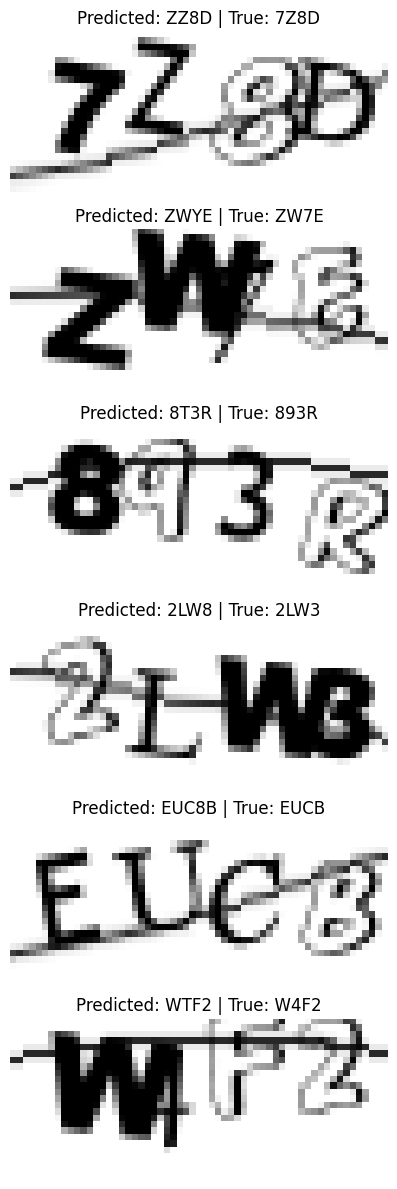

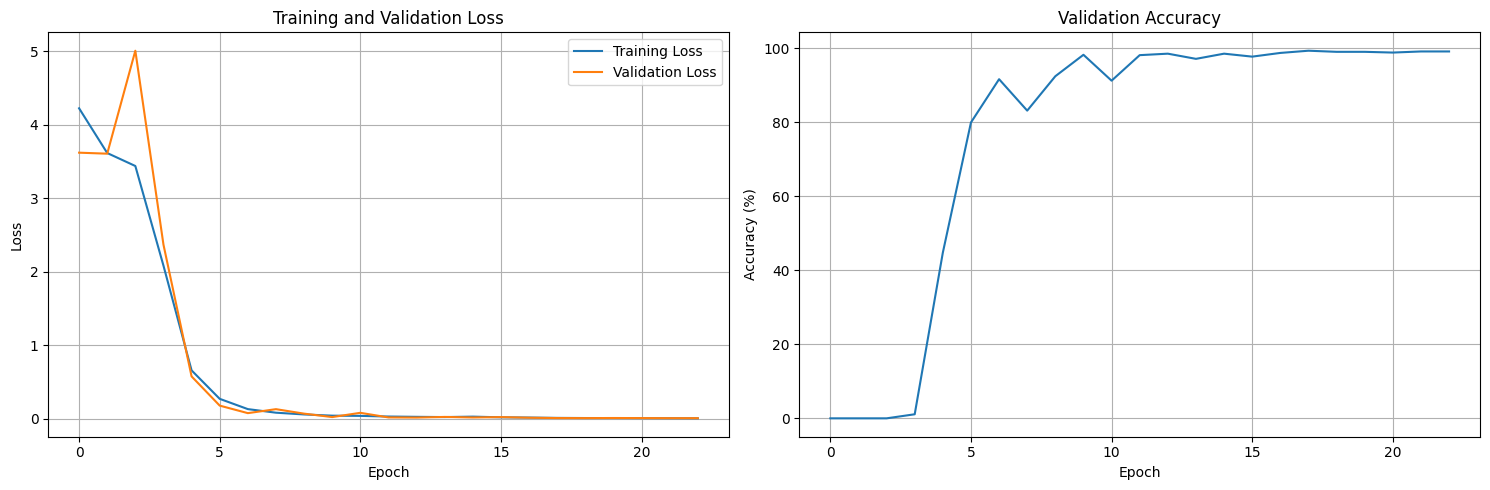

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Final accuracy: 99.40% (994/1000)


In [92]:
def train_model(model, train_loader, val_loader, idx_to_char, patience=5, min_delta=0.001):
    """Train the model and track performance metrics"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=CONFIG.LEARNING_RATE)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
      optimizer,
      max_lr=0.01,  # Peak learning rate
      epochs=CONFIG.NUM_EPOCHS,
      steps_per_epoch=len(train_loader),
      pct_start=0.2,  # Spend 20% of time warming up
      div_factor=25.0,  # Initial lr = max_lr/25
      final_div_factor=10000.0  # Final lr = max_lr/10000
    )

    # CTC Loss for sequence labeling
    criterion = nn.CTCLoss(blank=BLANK_TOKEN, zero_infinity=True)

    # History tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    import copy

    best_val_accuracy = 0.0
    best_model = copy.deepcopy(model.state_dict())
    epochs_without_improvement = 0

    for epoch in range(CONFIG.NUM_EPOCHS):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG.NUM_EPOCHS}"):
            images = batch['image'].to(device)
            labels = batch['label']
            label_lengths = batch['label_length']

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Prepare for CTC loss
            outputs_trans = outputs.transpose(0, 1)
            input_lengths = torch.full((outputs.size(0),), outputs.size(1), dtype=torch.long)

            # Calculate loss
            loss = criterion(outputs_trans, labels, input_lengths, label_lengths)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # SCHEDULER
            scheduler.step()

            train_loss += loss.item()

        # Average loss for the epoch
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Validation phase
        accuracy, val_loss, correct, total = evaluate_with_loss(
            model, val_loader, device, idx_to_char, criterion
        )
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(accuracy)

        # Log metrics
        print(f"Epoch {epoch+1}/{CONFIG.NUM_EPOCHS} - "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Validation Accuracy: {accuracy:.2f}% ({correct}/{total})")


        # EARLY STOPPING LOGIC
        if epoch < 10:
            continue

        if accuracy > best_val_accuracy + min_delta:
            best_val_accuracy = accuracy
            best_model = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1


        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    # Load the best model
    model.load_state_dict(best_model)

    # Save final model
    torch.save(model.state_dict(), CONFIG.MODEL_SAVE_PATH)
    print(f"Model saved to {CONFIG.MODEL_SAVE_PATH}")

    visualize_misclassifications(model, val_loader, device, idx_to_char, num_samples=8)


    return model, history

def main():
    try:
        # 1. Load and prepare data
        train_loader, val_loader, idx_to_char, max_length = load_and_prepare_data()

        # 2. Visualize sample images
        print("Visualizing sample images from dataset:")
        visualize_dataset_samples(train_loader, idx_to_char, num_samples=8)

        # 3. Create model
        num_chars = len(idx_to_char)
        model = CaptchaModel(num_chars)

        print("Model architecture:")
        print(f"{model}")

        # 4. Train model
        model, history = train_model(model, train_loader, val_loader, idx_to_char)

        # 5. Plot training history
        plot_history(history)

        # 6. Final evaluation
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        accuracy, val_loss, correct, total = evaluate_with_loss(
            model, val_loader, device, idx_to_char, nn.CTCLoss(blank=BLANK_TOKEN)
        )
        print(f"Final accuracy: {accuracy:.2f}% ({correct}/{total})")

        return model, history

    except Exception as e:
        print(f"Error in main function: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    model, history = main()